In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Selected features
Selected features dataset has 307511 observations and 21 features. No duplicates.

Selected features are mainly from current application. Aggregated features used from Previous applications (after feature selection): 
* AVG_Risk_Score (MEAN(df.NAME_YIELD_GROUP)) - risk ranking average, where the higher the number, the higher the risk
* SUM(df.CNT_PAYMENT) - sum of Terms in previous applications. This feature explodes in value when customer had more applications with long term plans.

<br>
From Pos_Cash_Balance dataset:

* Cluster_pos_cash_1: Customers with information on them starting a long high number of future instalments, but no data on them finishing the instalments.

In [45]:
selected_data = help_tool.csv_download(r'Archive\home-credit-default-risk\selected_data.csv').drop(columns='Unnamed: 0')
help_tool.first_look(selected_data)

Dataset has 307511 observations and 20 features
Columns with all empty values []
Dataset has 0 duplicates


dtypes Null values, Count Null values, %
OWN_CAR_AGE                 float64             202929           66.0
YEARS_BIRTH                 float64                  0            0.0
REGION_RATING_CLIENT          int64                  0            0.0
EXT_SOURCE_2                float64                660            0.2
OCCUPATION_TYPE             float64             112039           36.4
EXT_SOURCE_1                float64             173378           56.4
SUM(df.CNT_PAYMENT)         float64              16454            5.4
AMT_GOODS_PRICE             float64                278            0.1
AMT_CREDIT                  float64                  0            0.0
YEARS_LAST_PHONE_CHANGE     float64                  1            0.0
NAME_EDUCATION_TYPE           int64                  0            0.0
AMT_INCOME_TOTAL            float64                  0            0.0
AVG_Risk_Score              float64              18945            6.2
Cluster_pos_cash_1          float64              19258            6.3
CODE_GENDER_F               float64                  4            0.0
REGION_POPULATION_RELATIVE  float64                  0            0.0
YEARS_EMPLOYED              float64                  0            0.0
YEARS_ID_PUBLISH            float64                  0            0.0
EXT_SOURCE_3                float64              60965           19.8
TARGET                        int64                  0            0.0

## Null values
Features expected to have null values:
* MEAN(df.NAME_YIELD_GROUP)	and SUM(df.CNT_PAYMENT) - from previous applications, missing values mean that customer had no previous applications.
* Cluster_pos_cash_1 is from previous application, on position/cash balance. It is not missing when customer had a previous applications with specific products.
* EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1 are delivered through external vendours. Vendours may not have information on certain customers.

### OCCUPATION_TYPE 
OCCUPATION_TYPE is a function of coorporate hirarchy, where type 1 is Managers and High skill tech staff, type 3 - cooking/cleaning staff. Since OCCUPATION_TYPE is a function of income, it will not be used.

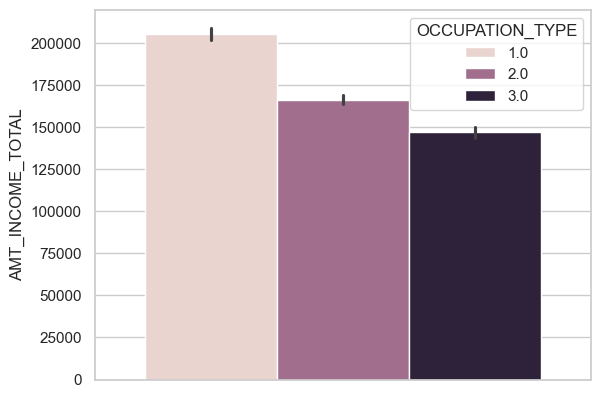

In [46]:
sns.barplot(data=selected_data.sample(20000, random_state=42), y='AMT_INCOME_TOTAL', hue='OCCUPATION_TYPE')
plt.show()

In [47]:
selected_data.drop(columns='OCCUPATION_TYPE', inplace=True)

### OWN_CAR_AGE
Another feature not expected to have null values is OWN_CAR_AGE. It could be that Age of Customers car is a function of Income, Age, Target. These hypotheses will be tested.

Null Hypothesis (H0): There is no relationship between 'OWN_CAR_AGE' and 'TARGET'. <br>
Alternative Hypothesis (H1): There is a relationship between 'CODE_GENDER' and 'TARGET'.

In [48]:
help_stats.significance_t_test(selected_data, 'OWN_CAR_AGE', 'TARGET', 0, 1)

p-value = nan between OWN_CAR_AGE and TARGET. Fail to reject null hypothesis


After Hypothesis testing with t-test, is is clear that Car age does not directly inpact Target.

#### Finding relations
On the other hand, having/not having a car could be realted to total income. This will be tested with 95% Confidence intervals.

In [49]:
help_stats.confidence_intervals(selected_data[selected_data['OWN_CAR_AGE'].isna()]['AMT_INCOME_TOTAL'], 'Continuous')
help_stats.confidence_intervals(selected_data[selected_data['OWN_CAR_AGE'].notna()]['AMT_INCOME_TOTAL'], 'Continuous')

Confidence Interval: [153418.82, 155792.85]
Confidence Interval: [195484.15, 197187.80]


95% Confidence intervals of Customer total income shows different ranges of confidence: 
* Customers with out a car make ~ 1.5 mill./year
* Customers with a car make ~ 1.9 mill./year
Thus, supporting a hypothesis that having a car is a function of income.

Next, let's test determine the confidence intervals for customer age, when customer has car/no car.

In [50]:
help_stats.confidence_intervals(selected_data[selected_data['OWN_CAR_AGE'].isna()]['YEARS_BIRTH'], 'Continuous')
help_stats.confidence_intervals(selected_data[selected_data['OWN_CAR_AGE'].notna()]['YEARS_BIRTH'], 'Continuous')

Confidence Interval: [45.00, 45.11]
Confidence Interval: [41.71, 41.84]


95% Confidence intervals for Customers without a car is ~41 years old, while Customers with cars are ~45 years old.

Conclussion: Car age does not have a impact on TARGET, but having a car is 95% Confidence intervals show that higher income Customers have cars. OWN_CAR_AGE has been determined to be related to AMT_INCOME_TOTAL and YEARS_BIRTH, and will be dropped.

In [51]:
selected_data.drop(columns='OWN_CAR_AGE', inplace=True)

# EDA
## Feature distribution

YEARS_BIRTH


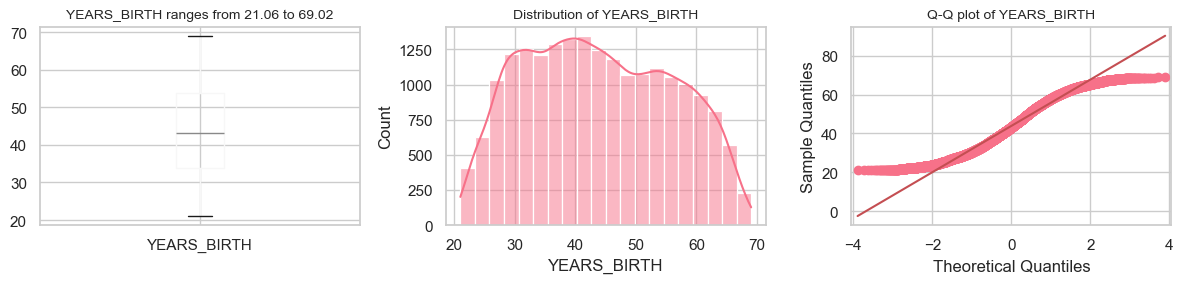

REGION_RATING_CLIENT


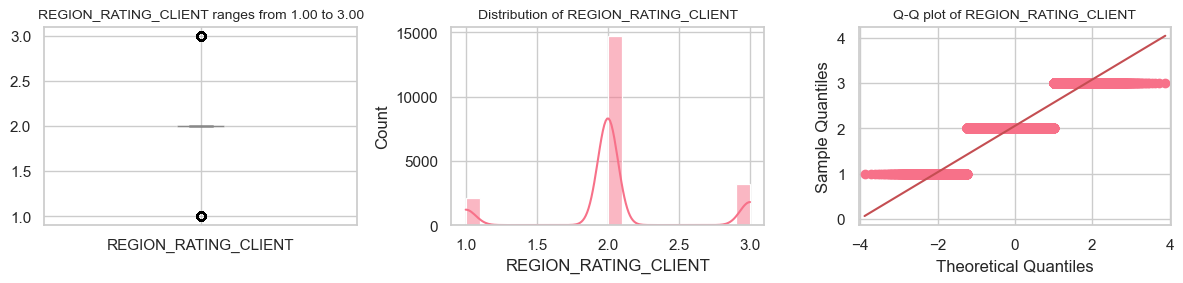

EXT_SOURCE_2


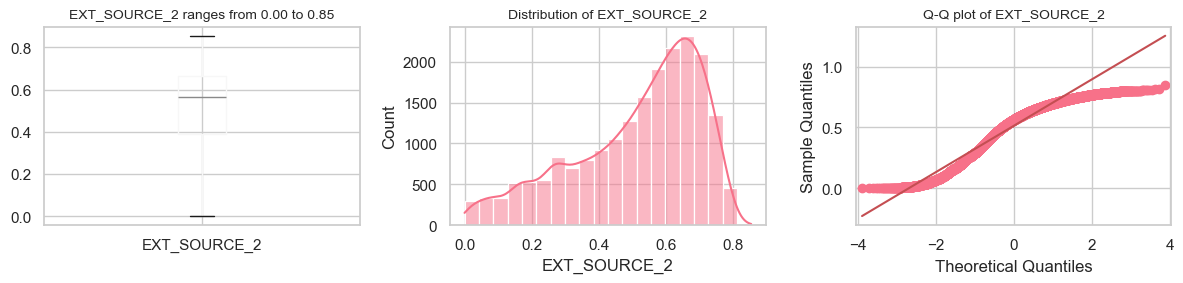

EXT_SOURCE_1


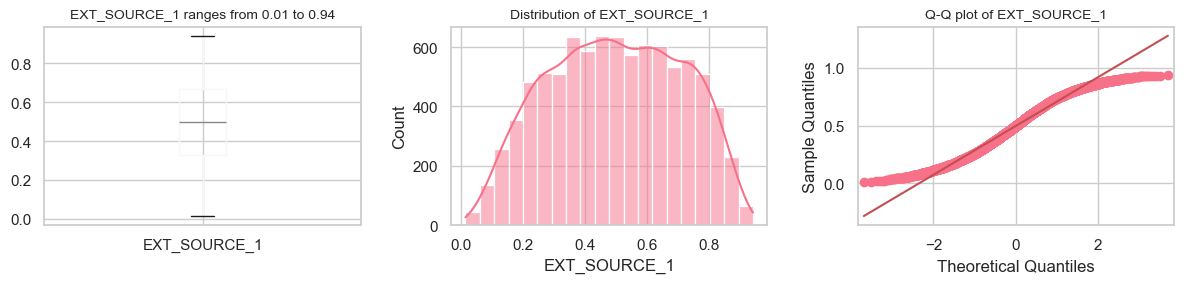

SUM(df.CNT_PAYMENT)


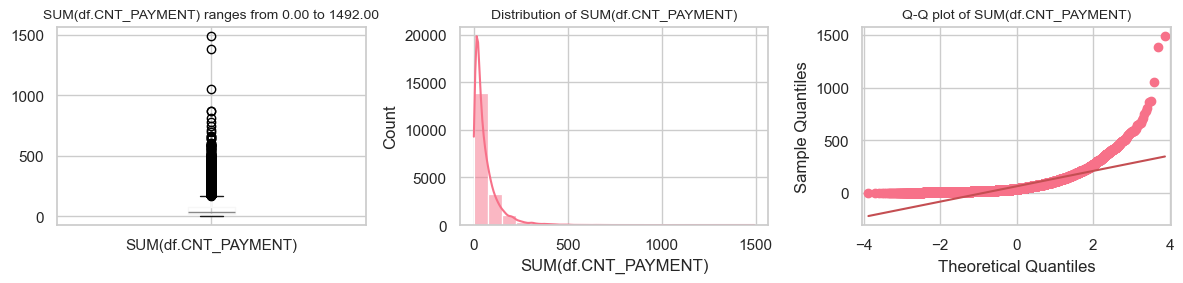

AMT_GOODS_PRICE


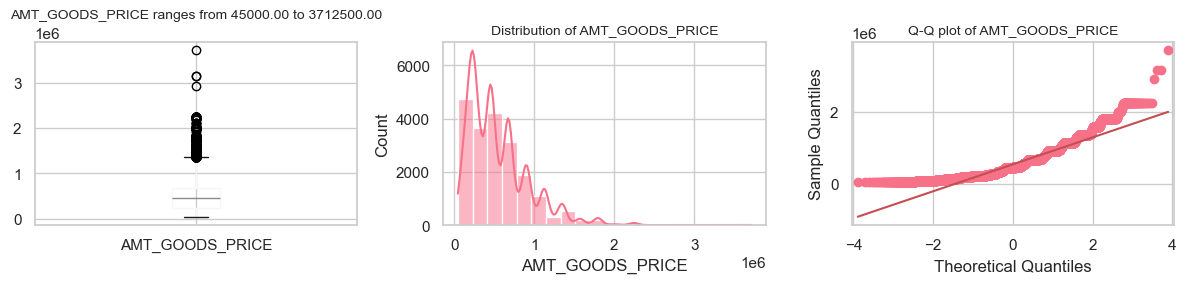

AMT_CREDIT


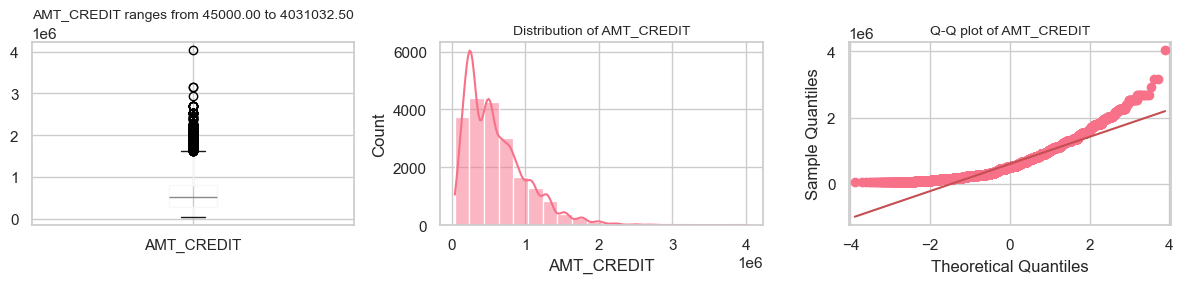

YEARS_LAST_PHONE_CHANGE


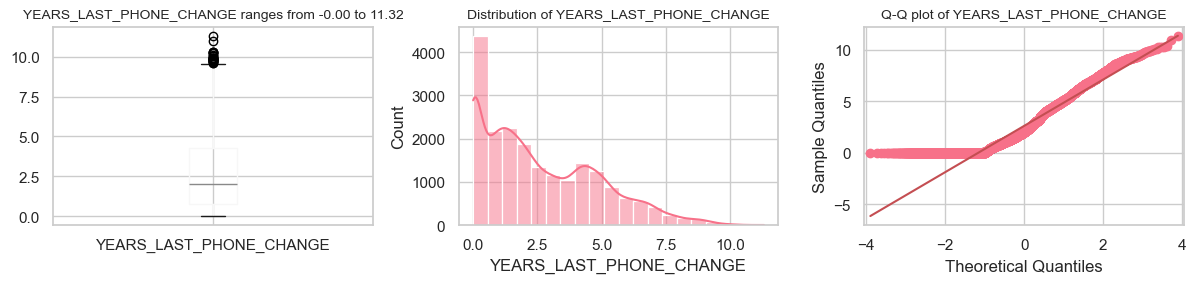

NAME_EDUCATION_TYPE


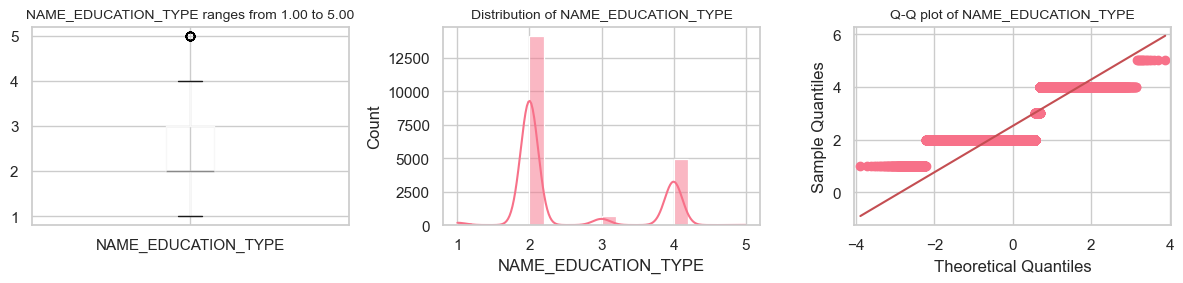

AMT_INCOME_TOTAL


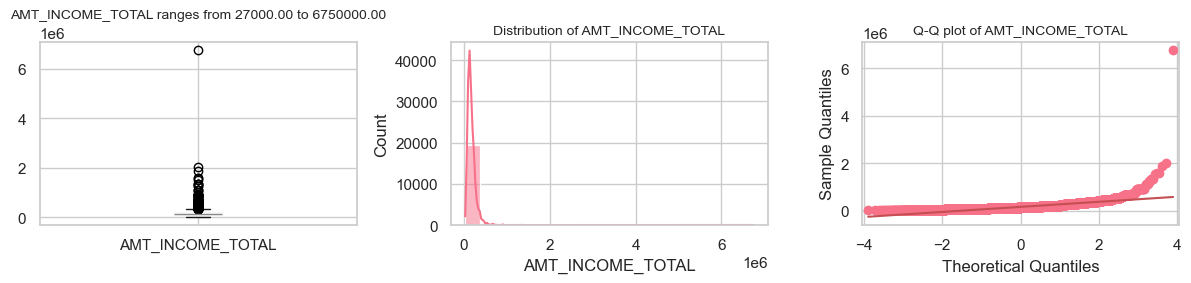

AVG_Risk_Score


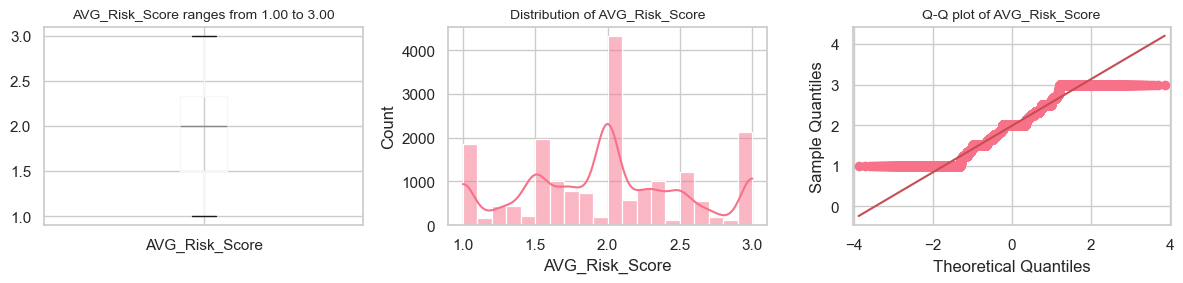

Cluster_pos_cash_1


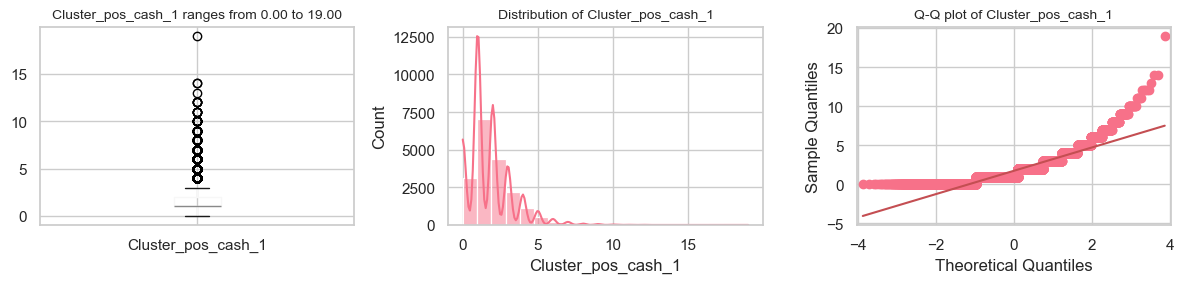

CODE_GENDER_F


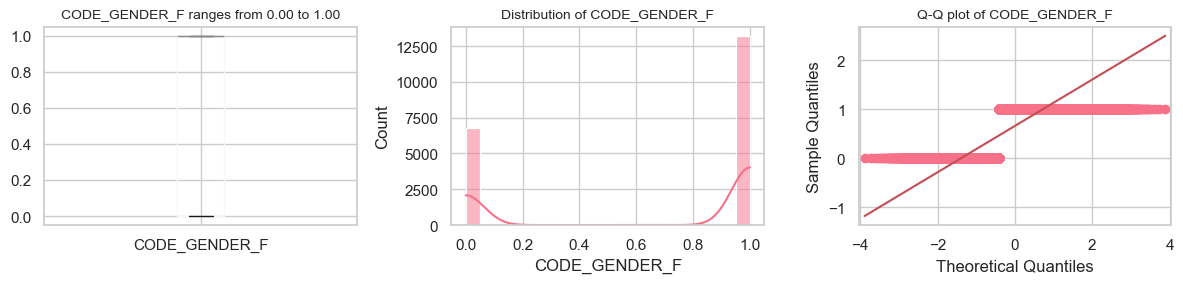

REGION_POPULATION_RELATIVE


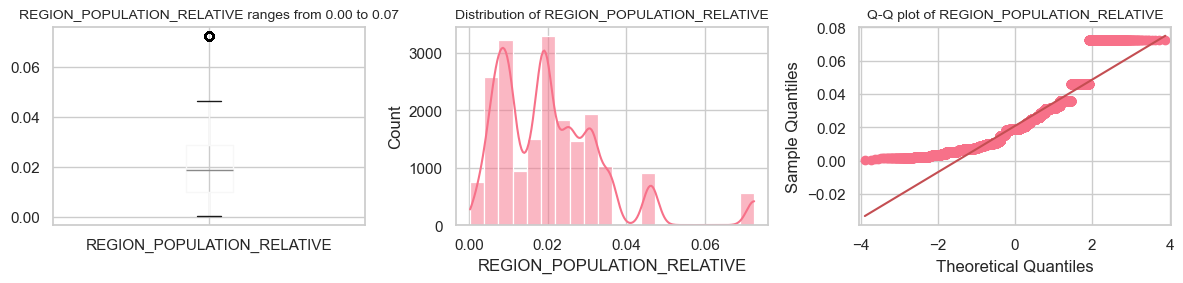

YEARS_EMPLOYED


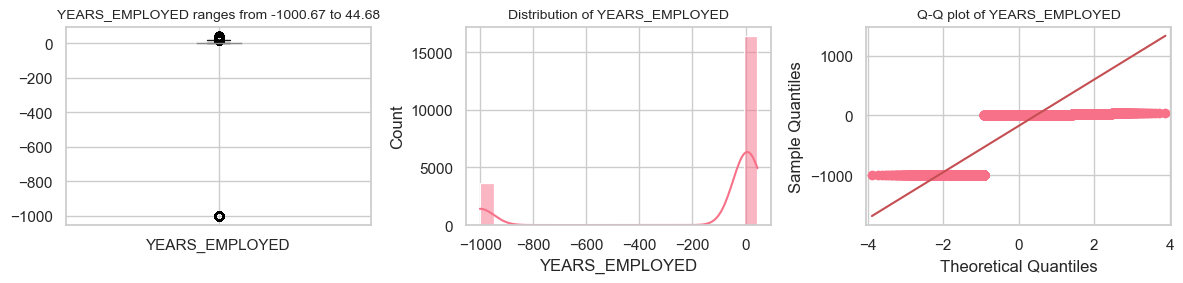

YEARS_ID_PUBLISH


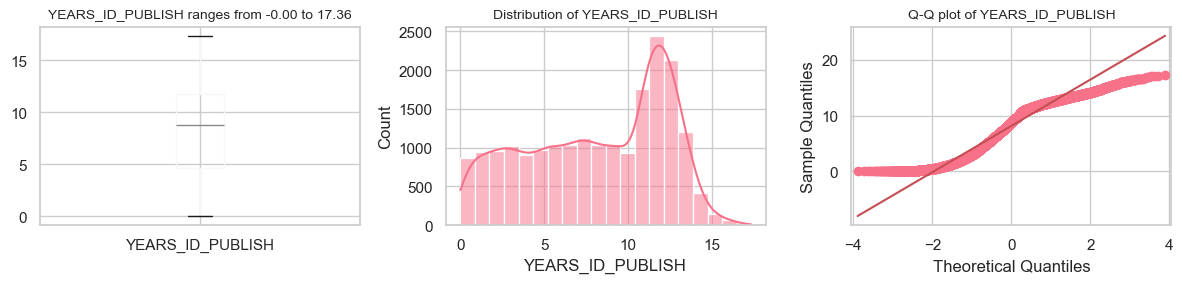

EXT_SOURCE_3


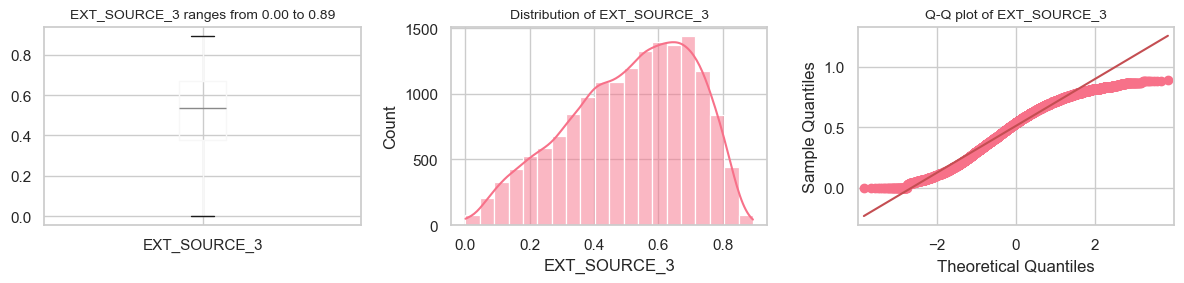

TARGET


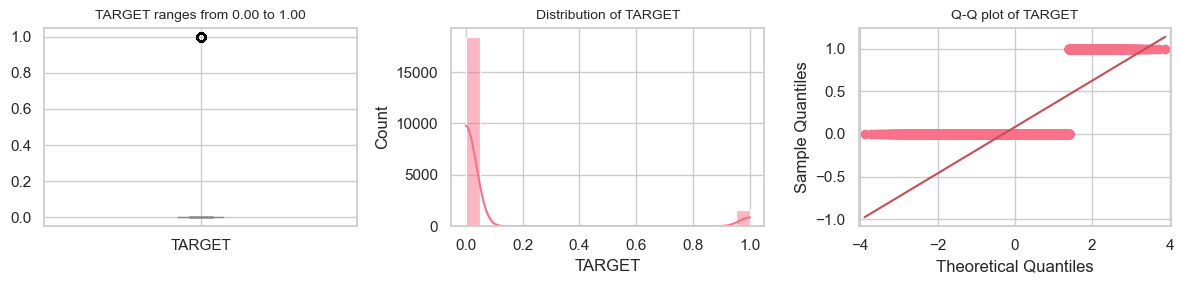

In [52]:
help_visuals.distribution_check(selected_data.sample(20000, random_state=42))

DAYS_EMPLOYED seams to have an error - it shows people being employed for 1000 years after their application

In [53]:
selected_data[selected_data['YEARS_EMPLOYED'] == selected_data['YEARS_EMPLOYED'].min()]['TARGET'].value_counts() / selected_data['TARGET'].value_counts() * 100

TARGET
0    18.530808
1    12.044310
Name: count, dtype: float64

Dropping these rows is not an option, as they make up ~12% of 'TARGET'=1. Instead, these values will be set to NaN.

In [54]:
selected_data.loc[selected_data['YEARS_EMPLOYED'] == selected_data['YEARS_EMPLOYED'].min(), 'YEARS_EMPLOYED'] = np.nan

## Buckets

In [55]:
def bucket_age_feature(df, age_feature):
    bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, float('inf')]
    labels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    df[f'{age_feature}_bucket'] = pd.cut(df[age_feature], bins=bins, labels=labels, right=True, include_lowest=True)
    
    return df[f'{age_feature}_bucket'].astype(float)

def equal_frequency_bucketing(df, feature, num_buckets):
    labels = [f'Bucket {i+1}' for i in range(num_buckets)]
    df[f'{feature}_bucket'] = pd.qcut(df[feature], q=num_buckets, labels=labels)
    
    return df[f'{feature}_bucket'] 

In [56]:
#selected_data['YEARS_BIRTH'] = bucket_age_feature(selected_data, 'YEARS_BIRTH')

In [57]:
#equal_frequency_bucketing(selected_data, 'YEARS_EMPLOYED', 5).value_counts()

In [58]:
#selected_data.filter(like='YEAR').describe()

In [59]:
#selected_data.filter(like='YEAR').isna().sum()

## Correlation

In [60]:
selected_data.columns

Index(['YEARS_BIRTH', 'REGION_RATING_CLIENT', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
       'SUM(df.CNT_PAYMENT)', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
       'YEARS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE', 'AMT_INCOME_TOTAL',
       'AVG_Risk_Score', 'Cluster_pos_cash_1', 'CODE_GENDER_F',
       'REGION_POPULATION_RELATIVE', 'YEARS_EMPLOYED', 'YEARS_ID_PUBLISH',
       'EXT_SOURCE_3', 'TARGET'],
      dtype='object')

In [63]:
binary_features = ['TARGET', 'CODE_GENDER_F', 'Cluster_pos_cash_1']

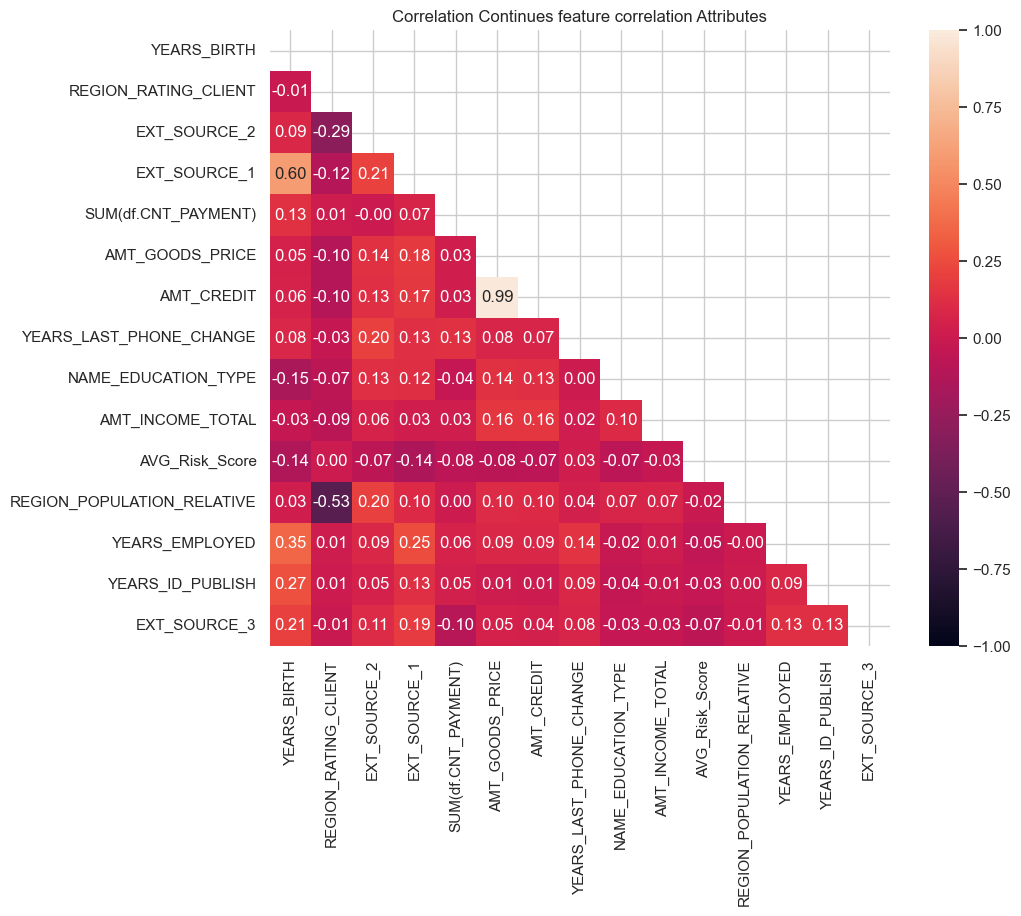

In [64]:
help_visuals.heatmap(selected_data.drop(columns=binary_features), 'Continues Feature correlation','pearson')
plt.show()

Continues feature correlation show AMT_CREDIT and AMT_GOODS_PRICE having almost perfect correlation. However, in feature selection it was seen that TARGET and EXT_SOURCE_1 relies on each of them.

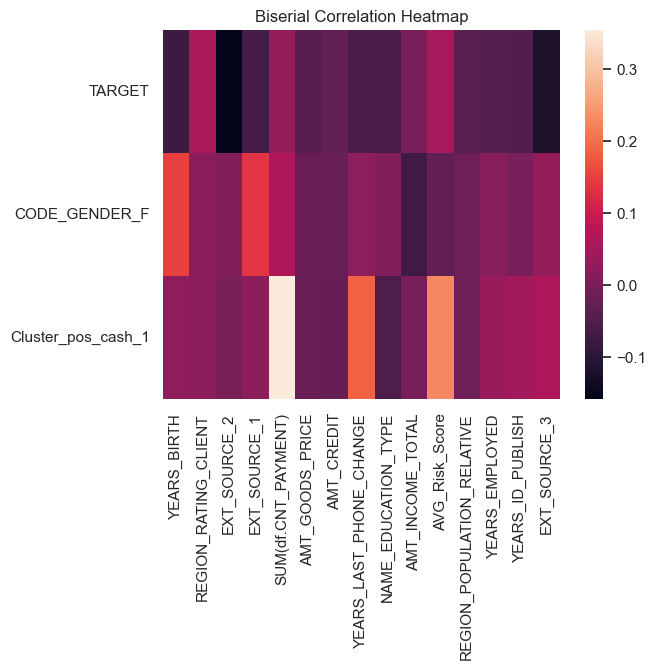

In [65]:
help_stats.biserial_heatmap(selected_data.fillna(0), selected_data.drop(columns=binary_features).columns, binary_features)

No biserial correlation.

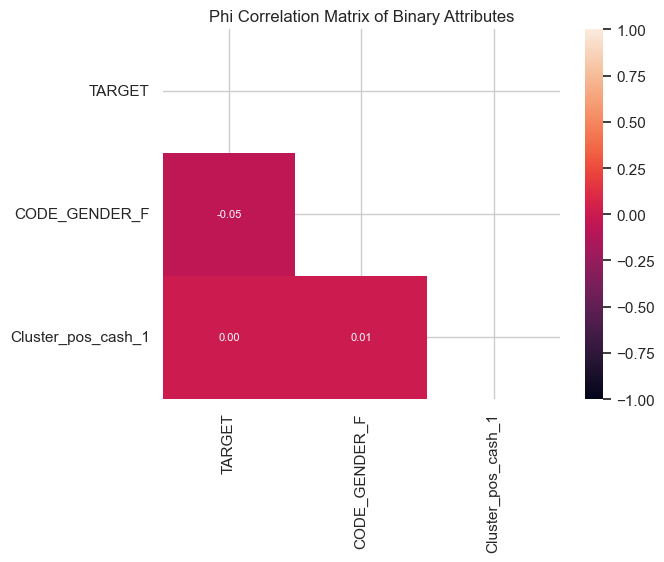

In [66]:
help_stats.phi_corr_matrix(selected_data.fillna(0), binary_features)

Also, binary features are not correalted to each other.

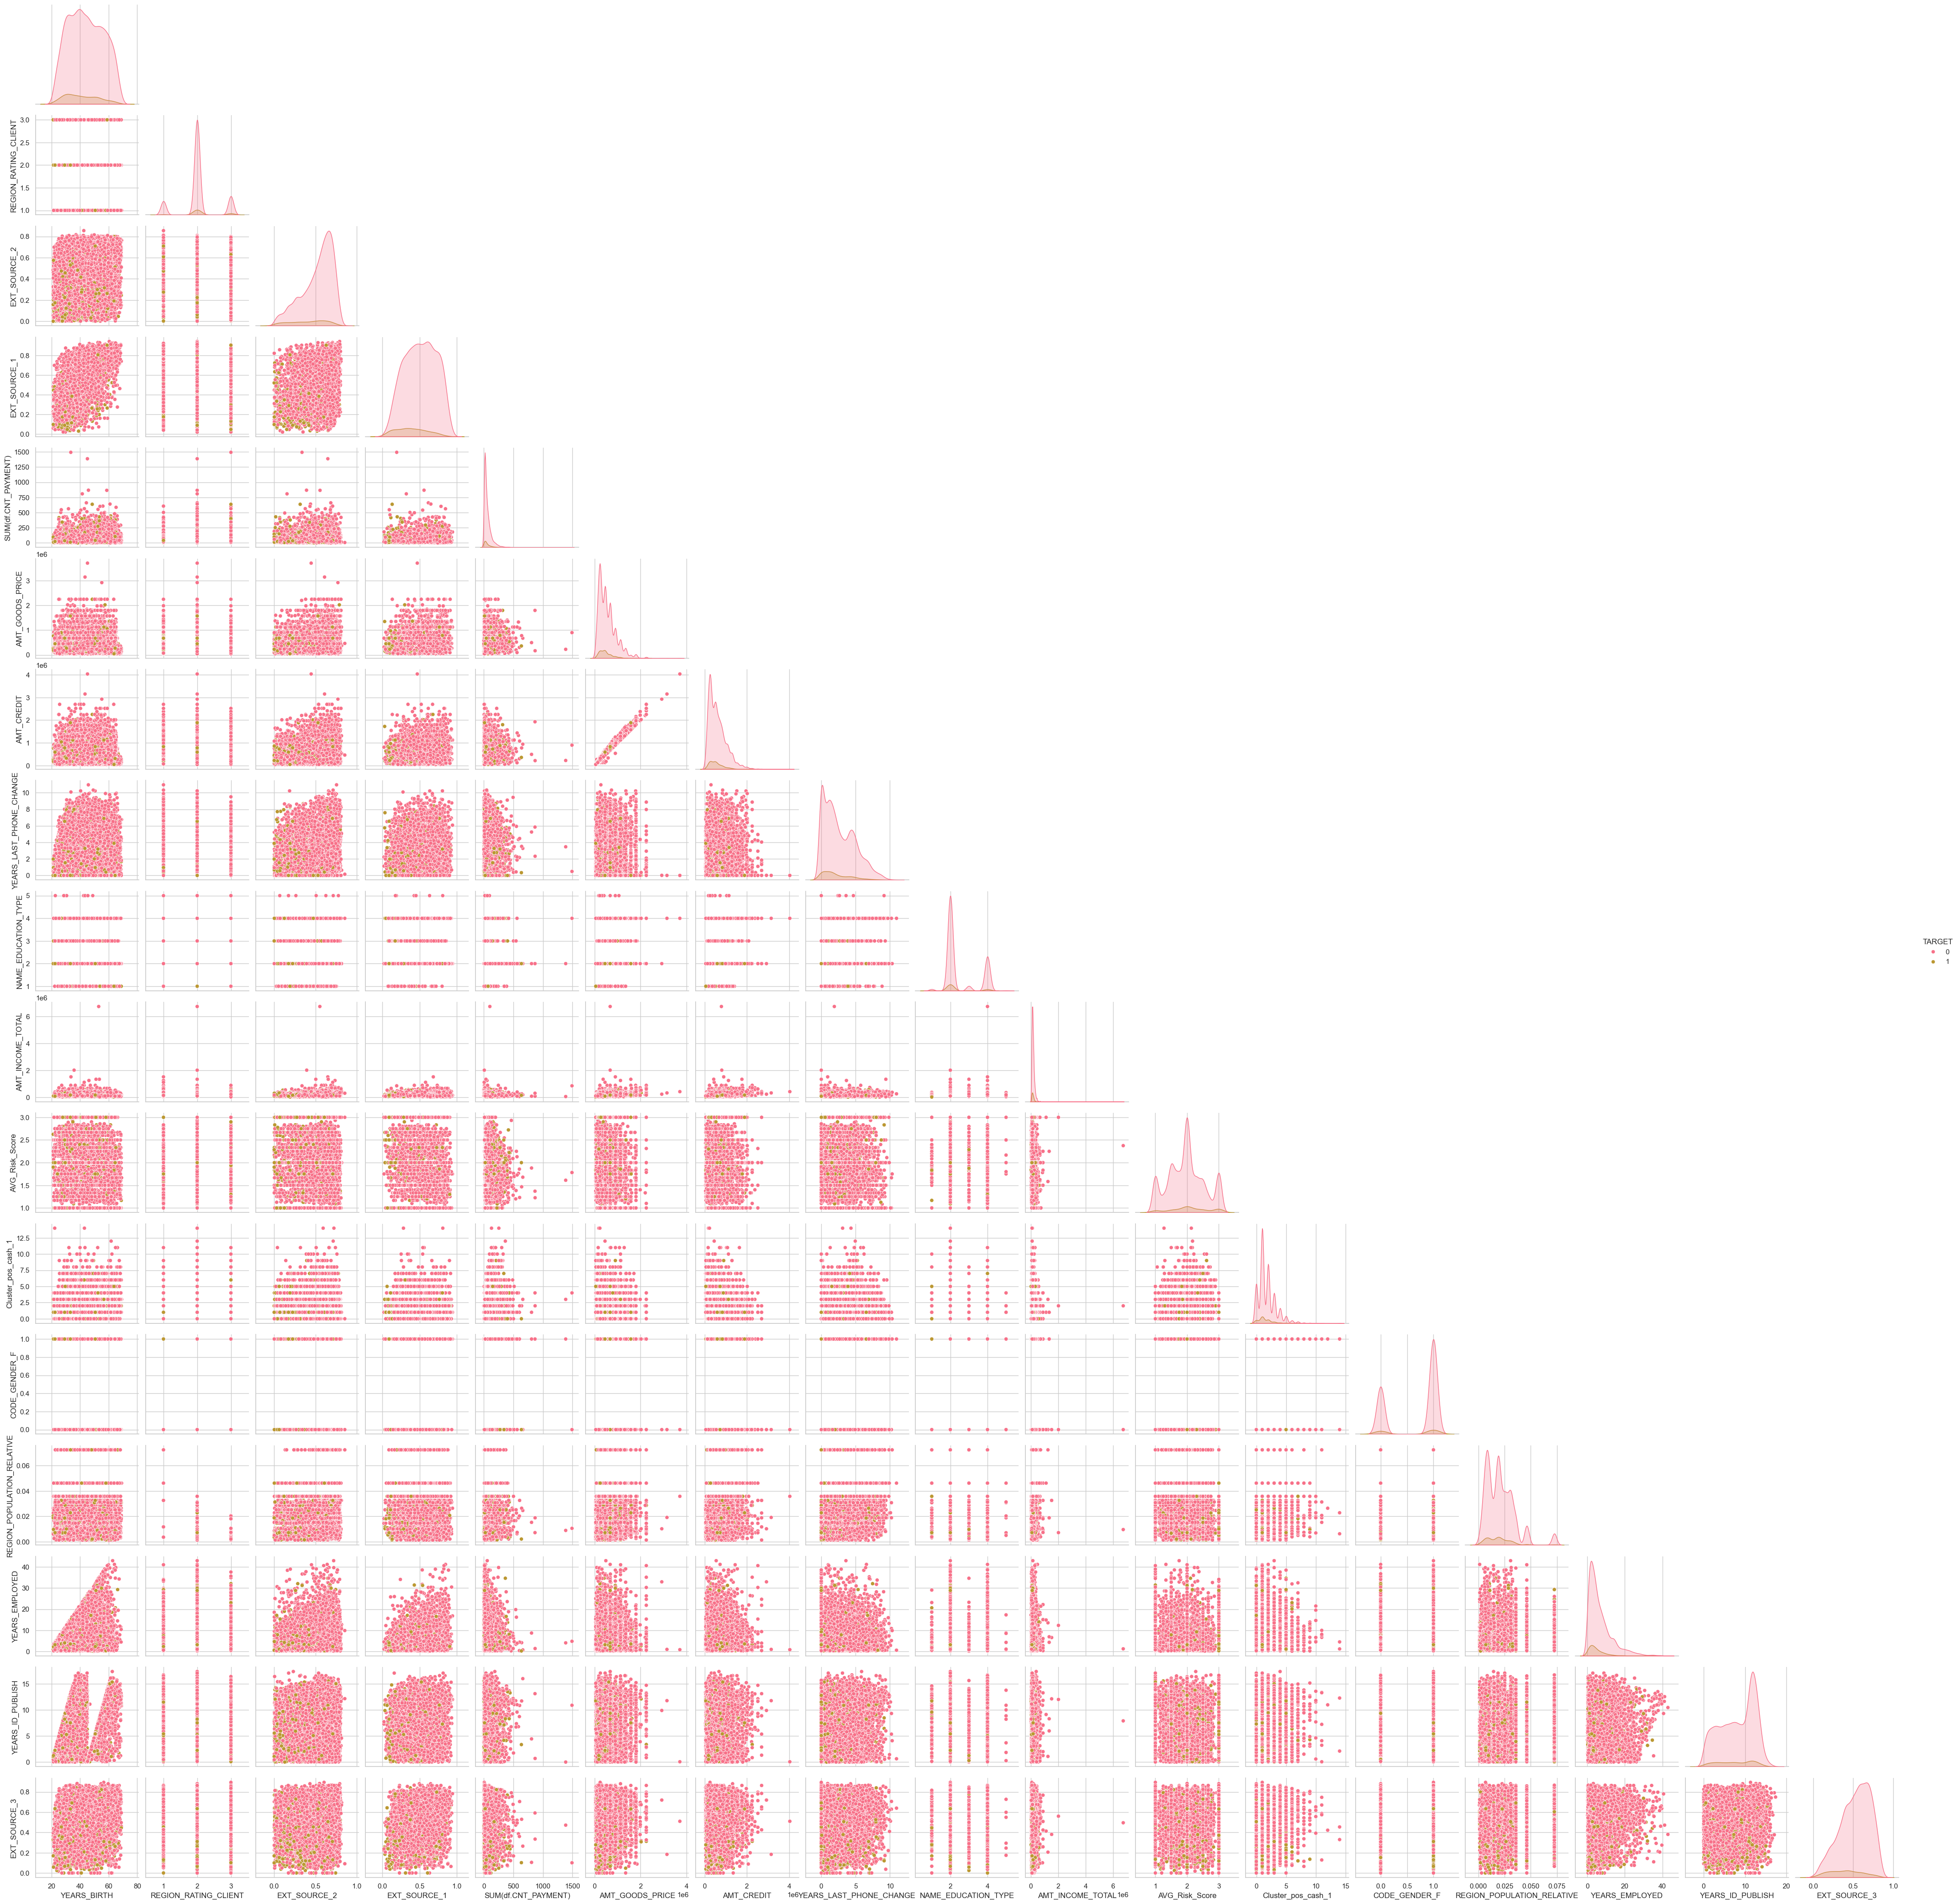

In [67]:
sns.pairplot(selected_data.sample(10000, random_state=42), corner=True, hue='TARGET')
plt.show()

binary_features

In [ ]:
binary_features

['TARGET', 'CODE_GENDER_F', 'NAME_FAMILY_STATUS', 'Cluster_pos_cash_1']

In [ ]:
selected_data.columns

Index(['YEARS_BIRTH', 'REGION_RATING_CLIENT', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
       'SUM(df.CNT_PAYMENT)', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
       'NAME_EDUCATION_TYPE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_INCOME_TOTAL',
       'AVG_Risk_Score', 'Cluster_pos_cash_1', 'CODE_GENDER_F',
       'REGION_POPULATION_RELATIVE', 'NAME_FAMILY_STATUS', 'YEARS_EMPLOYED',
       'YEARS_ID_PUBLISH', 'EXT_SOURCE_3', 'TARGET'],
      dtype='object')

In [ ]:
selected_data.head()

YEARS_BIRTH  REGION_RATING_CLIENT  EXT_SOURCE_2  EXT_SOURCE_1  \
0    26.205479                     2      0.638674      0.274852   
1    54.098630                     2      0.603948      0.817352   
2    63.775342                     2      0.558475           NaN   
3    49.328767                     2      0.504588      0.721364   
4    54.567123                     2      0.733470      0.792208   

   SUM(df.CNT_PAYMENT)  AMT_GOODS_PRICE  AMT_CREDIT  NAME_EDUCATION_TYPE  \
0                 48.0         225000.0    225000.0                    2   
1                 12.0         463500.0    536917.5                    2   
2                 28.0         270000.0    291384.0                    4   
3                  4.0         540000.0    646920.0                    2   
4                 72.0         270000.0    270000.0                    2   

   DAYS_LAST_PHONE_CHANGE  AMT_INCOME_TOTAL  AVG_Risk_Score  \
0                 -1735.0           85500.0        1.250000   
1                  -376.0          112500.0        2.000000   
2                 -1469.0          108000.0        1.000000   
3                     0.0          315000.0        3.000000   
4                 -1468.0          180000.0        1.833333   

   Cluster_pos_cash_1  CODE_GENDER_F  REGION_POPULATION_RELATIVE  \
0                 1.0            1.0                    0.014520   
1                 0.0            1.0                    0.010147   
2                 1.0            1.0                    0.030755   
3                 0.0            1.0                    0.011703   
4                 0.0            1.0                    0.035792   

   NAME_FAMILY_STATUS  YEARS_EMPLOYED  YEARS_ID_PUBLISH  EXT_SOURCE_3  TARGET  
0                 1.0        3.657534          6.109589      0.524496       0  
1                 1.0       11.213699          9.005479      0.609276       0  
2                 1.0       19.969863         12.493151      0.846378       0  
3                 2.0        2.794521          4.252055      0.562060       0  
4                 2.0       10.438356          9.331507      0.511892       0

In [ ]:
sns.histplot(data=selected_data, x='AVG_Risk_Score')

* Do genders/age groups have different Risk Scores of previous applications?

In [ ]:
help_stats.significance_t_test(selected_data, 'AVG_Risk_Score', 'CODE_GENDER_F', 0, 1)

p-value = nan between AVG_Risk_Score and CODE_GENDER_F. Fail to reject null hypothesis


In [ ]:
help_stats.pearson_correlation_test(selected_data.dropna(subset='AVG_Risk_Score'), 'AVG_Risk_Score', 'YEARS_BIRTH')

p-value = 0.0000 between AVG_Risk_Score and YEARS_BIRTH. Reject null hypothesis


In [ ]:
help_stats.pearson_correlation_test(selected_data.dropna(subset=['AVG_Risk_Score', 'YEARS_EMPLOYED']), 'AVG_Risk_Score', 'YEARS_EMPLOYED')

p-value = 0.0000 between AVG_Risk_Score and YEARS_EMPLOYED. Reject null hypothesis


* Do different Education type + Age influence Ext_Source?

In [ ]:
help_stats.pearson_correlation_test(selected_data.dropna(subset=['EXT_SOURCE_1', 'REGION_RATING_CLIENT']), 'EXT_SOURCE_1', 'REGION_RATING_CLIENT')

p-value = 0.0000 between EXT_SOURCE_1 and REGION_RATING_CLIENT. Reject null hypothesis
